In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from dis2p import dis2pvi_cE as dvi
# from dis2p_reproducibility.dis2p_defunct import dis2pvi_cE as dvi
import biolord
from scvi.model.base import BaseModelClass
from scDisInFact import scdisinfact, create_scdisinfact_dataset

# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib
import rapids_singlecell as rsc

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
import gc
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [2]:
RANDOM_SEED = 42

adata = sc.read_h5ad('/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/haber_hvg_split.h5ad')
adata_biolord = sc.read_h5ad('/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/haber_hvg_split.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()
adata_biolord = adata_biolord[adata_biolord.layers['counts'].sum(1) != 0].copy()

cats = ['batch', 'condition', 'cell_label',]
condition_key = ['batch', 'condition', 'cell_label',]

#scDisInfact Related Data
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1
Ks = [40] + [10] * len(condition_key)
batch_size = 64
interval = 10
lr = 5e-4
batch_size = 64
adata_ = adata[adata.layers['counts'].sum(1) != 0].copy()
counts = adata_.layers['counts'].copy()
meta_cells = adata_.obs.copy()
meta_cells['one'] = pd.Categorical([1 for _ in range(adata_.n_obs)])
data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key = condition_key, batch_key = "one")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
del adata_

gc.collect()

from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()


cov_names = ['condition']
cov_values = ['Control']
cov_values_cf = ['Salmonella']

n_samples_from_source_max = 500

pre_path = '/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models/'

def load_models(
    dis2p_model_path: str,
    biolord_model_path: str,
    scdisinfact_model_path: str,
):
    model = dvi.Dis2pVI_cE.load(f"{pre_path}/{dis2p_model_path}", adata=adata)
    biolord_model = biolord.Biolord.load(f"{pre_path}/{biolord_model_path}", adata=adata_biolord)
    
    scdisinfact_model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                        reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class, 
                        reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
    scdisinfact_model.load_state_dict(torch.load(f"{pre_path}/{scdisinfact_model_path}", map_location = device))
    
    return model, biolord_model, scdisinfact_model


Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


In [12]:
adata.obs['cell_label'].unique()

['Enterocyte.Progenitor', 'Stem', 'TA.Early', 'TA', 'Tuft', 'Enterocyte', 'Goblet', 'Endocrine']
Categories (8, object): ['Endocrine', 'Enterocyte', 'Enterocyte.Progenitor', 'Goblet', 'Stem', 'TA', 'TA.Early', 'Tuft']

In [17]:
scenario = 'allOut'
# cell_type_to_check = 'Endocrine'
# cond_path_name = 'salmonella'

cell_type_to_check = 'TA.Early'
cond_path_name = 'hpoly10'

dis2p_model_path = (
    f'dis2p_cE_split_{scenario}_{cell_type_to_check}_{cond_path_name}/'
    f'pretrainAE_0_maxEpochs_1000_split_split_{scenario}_{cell_type_to_check}_{cond_path_name}_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_new_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2'
)
biolord_model_path = f'biolord/haber_biolord_earlierStop_basicSettings_nb_split_{scenario}_{cell_type_to_check}_{cond_path_name}/'
scdisinfact_model_path = f'scDisInfact/haber_scdisinfact_defaultSettings_fsplit_{scenario}_{cell_type_to_check}_{cond_path_name}.pth'

model, biolord_model, scdisinfact_model = load_models(dis2p_model_path, biolord_model_path, scdisinfact_model_path)

INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models//dis2p_cE_split_allOut_TA.Early_hpoly10/pretrai
         nAE_0_maxEpochs_1000_split_split_allOut_TA.Early_hpoly10_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.
         014_advp_5_n_cf_1_lr_0.003_wd_5e-05_new_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2/model.pt  
         already downloaded                                                                                        
INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models//biolord/haber_biolord_earlierStop_basicSetting
         s_nb_split_allOut_TA.Early_hpoly10/model.pt already downloaded                                            


Global seed set to 42


In [18]:
# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

In [19]:
for i, cat in enumerate(cats):
    nullify = [c for c in cats if c != cat]
    latent_unknown_attributes_adata, latent_adata = biolord_model.get_latent_representation_adata(
        adata=adata_biolord,
        nullify_attribute=nullify,
    )
    adata.obsm[f'Biolord_Z_{i+1}'] = latent_adata.X.copy()

    nullify = [cat]
    latent_unknown_attributes_adata, latent_adata = biolord_model.get_latent_representation_adata(
        adata=adata_biolord,
        nullify_attribute=nullify,
    )
    adata.obsm[f'Biolord_Z_not_{i+1}'] = latent_adata.X.copy()

adata.obsm[f'Biolord_Z_0'] = latent_unknown_attributes_adata.X.copy()

In [20]:
# one forward pass
z_cs = []
z_ds = []
zs = []

# loop through all training count matrices
for dataset in data_dict["datasets"]:
    with torch.no_grad():
        # pass through the encoders
        dict_inf = scdisinfact_model.inference(counts = dataset.counts_norm.to(scdisinfact_model.device), batch_ids = dataset.batch_id[:,None].to(scdisinfact_model.device), print_stat = False)
        # pass through the decoder
        dict_gen = scdisinfact_model.generative(z_c = dict_inf["mu_c"], z_d = dict_inf["mu_d"], batch_ids = dataset.batch_id[:,None].to(scdisinfact_model.device))
        z_c = dict_inf["mu_c"]
        z_d = dict_inf["mu_d"]
        mu = dict_gen["mu"]    
        z_ds.append([x.cpu().detach().numpy() for x in z_d])
        z_cs.append(z_c.cpu().detach().numpy())

# shared-bio factor, concatenate across all training matrices
z_cs = np.concatenate(z_cs, axis = 0)
adata.obsm[f'scDisInfact_Z_0'] = z_cs.copy()

# unshared-bio factors for conditions 1 and 2
for i, cat in enumerate(cats):
    z_ds_cond = np.concatenate([x[i] for x in z_ds], axis = 0)
    adata.obsm[f'scDisInfact_Z_{i+1}'] = z_ds_cond.copy()

for i in range(1, len(cats)+1):
    z_not_ds_cond = np.concatenate([adata.obsm[f'scDisInfact_Z_{j}'].copy() for j in range(len(cats)+1) if j != i], axis=1)
    adata.obsm[f'scDisInfact_Z_not_{i}'] = z_not_ds_cond.copy()

In [21]:
adata

AnnData object with n_obs × n_vars = 9842 × 7000
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'ct_cond', 'split_allOut_Enterocyte.Progenitor_salmonella', 'split_allOut_Stem_salmonella', 'split_allOut_TA.Early_salmonella', 'split_allOut_TA_salmonella', 'split_allOut_Tuft_salmonella', 'split_allOut_Enterocyte_salmonella', 'split_allOut_Goblet_salmonella', 'split_allOut_Endocrine_salmonella', 'split_allOut_Enterocyte.Progenitor_hpoly10', 'split_allOut_Stem_hpoly10', 'split_allOut_TA.Early_hpoly10', 'split_allOut_TA_hpoly10', 'split_allOut_Tuft_hpoly10', 'split_allOut_Enterocyte_hpoly10', 'split_allOut_Goblet_hpoly10', 'split_allOut_Endocrine_hpoly10', 'split_targetOut_Enterocyte.Progenitor_salmonella', 'split_targetOut_Stem_salmonella', 'split_targetOut_TA.Early

In [22]:
cats

['batch', 'condition', 'cell_label']

In [23]:
for label_key in cats:
    adata.obs[label_key] = adata.obs[label_key].astype('category')

In [24]:
from scib_metrics.benchmark import (
    BatchCorrection,
    Benchmarker,
    BioConservation,
)

bms = {}
batch_correction_metrics = BatchCorrection(silhouette_batch=False)

for label_key in cats:
    print(f"Label: {label_key}")
    bms[label_key] = {}
    label_ind = cats.index(label_key) + 1
    embedding_obsm_keys = [f'dis2p_cE_Z_{label_ind}', 
                           f'Biolord_Z_{label_ind}',
                           f'scDisInfact_Z_{label_ind}',]
    for batch_key in cats:
        if batch_key == label_key:
            continue
        print(f"Batch: {batch_key}")
        bm = Benchmarker(
            adata,
            batch_key=batch_key,
            label_key=label_key,
            embedding_obsm_keys=embedding_obsm_keys,
            batch_correction_metrics=batch_correction_metrics,
            n_jobs=-1,
            )
        bm.benchmark()
        bms[label_key][batch_key] = bm

Label: batch
Batch: condition


Metrics:  50%|█████     | 5/10 [00:53<00:39,  7.82s/it, Batch correction: kbet_per_label]

INFO     B1 consists of a single batch or is too small. Skip.                                                      
INFO     B10 consists of a single batch or is too small. Skip.                                                     
INFO     B2 consists of a single batch or is too small. Skip.                                                      
INFO     B3 consists of a single batch or is too small. Skip.                                                      
INFO     B4 consists of a single batch or is too small. Skip.                                                      
INFO     B5 consists of a single batch or is too small. Skip.                                                      
INFO     B6 consists of a single batch or is too small. Skip.                                                      
INFO     B7 consists of a single batch or is too small. Skip.                                                      
INFO     B8 consists of a single batch or is too small. Skip.           


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [00:23<00:16,  3.36s/it, Batch correction: kbet_per_label]

INFO     B1 consists of a single batch or is too small. Skip.                                                      
INFO     B10 consists of a single batch or is too small. Skip.                                                     
INFO     B2 consists of a single batch or is too small. Skip.                                                      
INFO     B3 consists of a single batch or is too small. Skip.                                                      
INFO     B4 consists of a single batch or is too small. Skip.                                                      
INFO     B5 consists of a single batch or is too small. Skip.                                                      
INFO     B6 consists of a single batch or is too small. Skip.                                                      
INFO     B7 consists of a single batch or is too small. Skip.                                                      
INFO     B8 consists of a single batch or is too small. Skip.           


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [00:02<00:02,  2.37it/s, Batch correction: kbet_per_label]

INFO     B1 consists of a single batch or is too small. Skip.                                                      
INFO     B10 consists of a single batch or is too small. Skip.                                                     
INFO     B2 consists of a single batch or is too small. Skip.                                                      
INFO     B3 consists of a single batch or is too small. Skip.                                                      
INFO     B4 consists of a single batch or is too small. Skip.                                                      
INFO     B5 consists of a single batch or is too small. Skip.                                                      
INFO     B6 consists of a single batch or is too small. Skip.                                                      
INFO     B7 consists of a single batch or is too small. Skip.                                                      
INFO     B8 consists of a single batch or is too small. Skip.           


Embeddings: 100%|████   | 7/10 [00:02<00:01,  2.93it/s, Batch correction: pcr_comparison]    ██████████| 3/3 [01:19<00:00, 20.79s/it]██████████| 3/3 [01:19<00:00, 26.61s/it]

                                                                                         

Batch: cell_label


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|████   | 7/10 [00:08<00:05,  1.83s/it, Batch correction: pcr_comparison]    ██████████| 3/3 [01:29<00:00, 24.52s/it]██████████| 3/3 [01:29<00:00, 29.93s/it]

                                                                                         

Label: condition
Batch: batch


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|████   | 7/10 [00:08<00:06,  2.00s/it, Batch correction: pcr_comparison]    ██████████| 3/3 [01:31<00:00, 25.06s/it]██████████| 3/3 [01:31<00:00, 30.42s/it]

                                                                                         

Batch: cell_label


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|████   | 7/10 [00:08<00:05,  1.87s/it, Batch correction: pcr_comparison]    ██████████| 3/3 [01:37<00:00, 26.55s/it]██████████| 3/3 [01:37<00:00, 32.44s/it]

                                                                                         

Label: cell_label
Batch: batch


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|████   | 7/10 [00:07<00:04,  1.51s/it, Batch correction: pcr_comparison]    ██████████| 3/3 [01:44<00:00, 28.04s/it]██████████| 3/3 [01:44<00:00, 34.95s/it]

                                                                                         

Batch: condition


Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Embeddings: 100%|████   | 7/10 [00:08<00:05,  1.95s/it, Batch correction: pcr_comparison]    ██████████| 3/3 [01:40<00:00, 27.24s/it]██████████| 3/3 [01:40<00:00, 33.54s/it]

                                                                                         

In [ ]:
for label, d in bms.items():
    for batch, bm in d.items():
        print(label)
        print(batch)
        bm.plot_results_table(min_max_scale=False)
        print()

In [ ]:
df_cat

In [25]:
all_bms = []
for label, d in bms.items():
    for batch, bm in d.items():
        all_bms.append(bm.get_results(min_max_scale=False).iloc[:-1] )

df_cat = pd.concat(all_bms)
df_cat['Model'] = df_cat.index.str[:-4]
df_mean = df_cat.groupby('Model').mean()
df_mean.loc['Metric Type'] = bm.get_results(min_max_scale=False).loc['Metric Type']
df_mean

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Model,,,,,,,,,,,,
Biolord,0.512764,0.508595,0.430691,0.511979,0.792365,0.461612,0.955726,0.713173,0.823139,0.723492,0.551279,0.620164
dis2p_cE,0.62063,0.876978,0.785958,0.62062,1.0,0.344475,0.811491,0.909685,0.549605,0.632562,0.780837,0.721527
scDisInfact,0.521612,0.368604,0.276509,0.524275,0.709065,0.365383,0.479983,0.540934,0.489463,0.459172,0.480013,0.471677
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


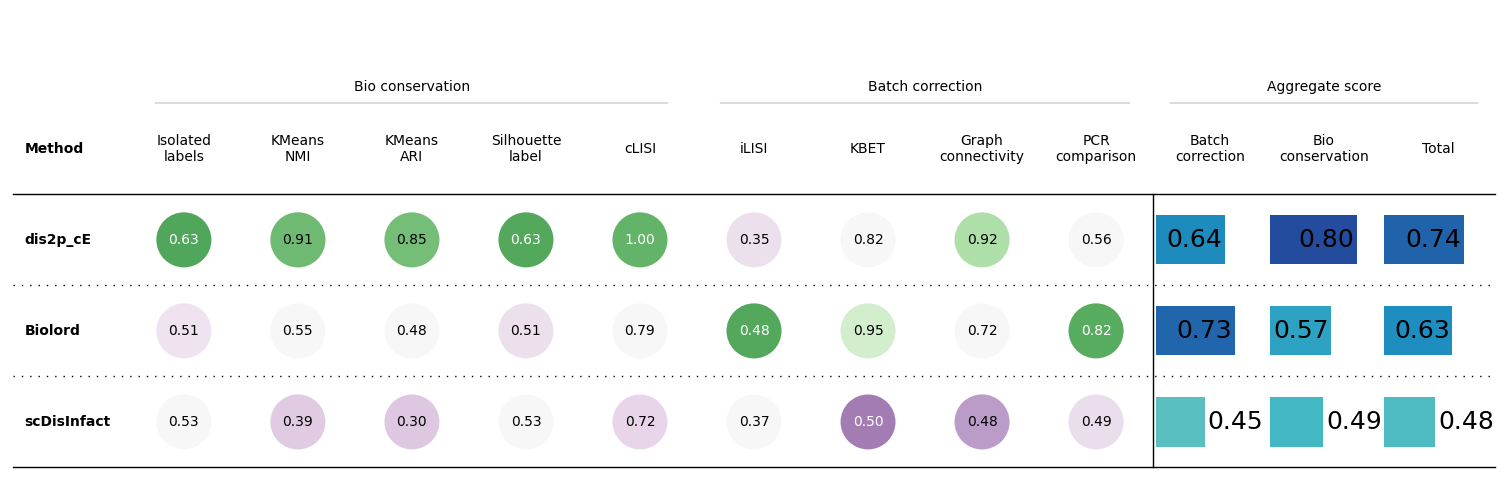

In [15]:
from typing import Any, Callable, Optional, Union

def plot_results_table(
    df, show: bool = True, save_dir: Optional[str] = None
):
    import os
    import warnings
    from dataclasses import asdict, dataclass
    from enum import Enum
    from functools import partial
    from typing import Any, Callable, Optional, Union

    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import scanpy as sc
    from anndata import AnnData
    from plottable import ColumnDefinition, Table
    from plottable.cmap import normed_cmap
    from plottable.plots import bar
    from sklearn.preprocessing import MinMaxScaler
    from tqdm import tqdm

    import scib_metrics
    from scib_metrics.nearest_neighbors import NeighborsResults, pynndescent

    Kwargs = dict[str, Any]
    MetricType = Union[bool, Kwargs]
    """Plot the benchmarking results.

    Parameters
    ----------
    min_max_scale
        Whether to min max scale the results.
    show
        Whether to show the plot.
    save_dir
        The directory to save the plot to. If `None`, the plot is not saved.
    """
    _LABELS = "labels"
    _BATCH = "batch"
    _X_PRE = "X_pre"
    _METRIC_TYPE = "Metric Type"
    _AGGREGATE_SCORE = "Aggregate score"

    num_embeds = len(df) - 1
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)
    # Do not want to plot what kind of metric it is
    plot_df = df.drop(_METRIC_TYPE, axis=0)
    # Sort by total score
    plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)
    plot_df["Method"] = plot_df.index

    # Split columns by metric type, using df as it doesn't have the new method col
    score_cols = df.columns[df.loc[_METRIC_TYPE] == _AGGREGATE_SCORE]
    other_cols = df.columns[df.loc[_METRIC_TYPE] != _AGGREGATE_SCORE]
    column_definitions = [
        ColumnDefinition("Method", width=1., textprops={"ha": "left", "weight": "bold"}),
    ]
    # Circles for the metric values
    column_definitions += [
        ColumnDefinition(
            col,
            title=col.replace(" ", "\n", 1),
            width=1,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.8},
            },
            cmap=cmap_fn(plot_df[col]),
            group=df.loc[_METRIC_TYPE, col],
            formatter="{:.2f}",
        )
        for i, col in enumerate(other_cols)
    ]
    # Bars for the aggregate scores
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": matplotlib.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            group=df.loc[_METRIC_TYPE, col],
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(score_cols)
    ]
    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1.6, 3 + 1 * num_embeds))
        tab = Table(
            plot_df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=plot_df.columns)
    if show:
        plt.show()
    if save_dir is not None:
        fig.savefig(os.path.join(save_dir, "scib_results.svg"), facecolor=ax.get_facecolor(), dpi=300)

    return tab
plot_results_table(df_mean)

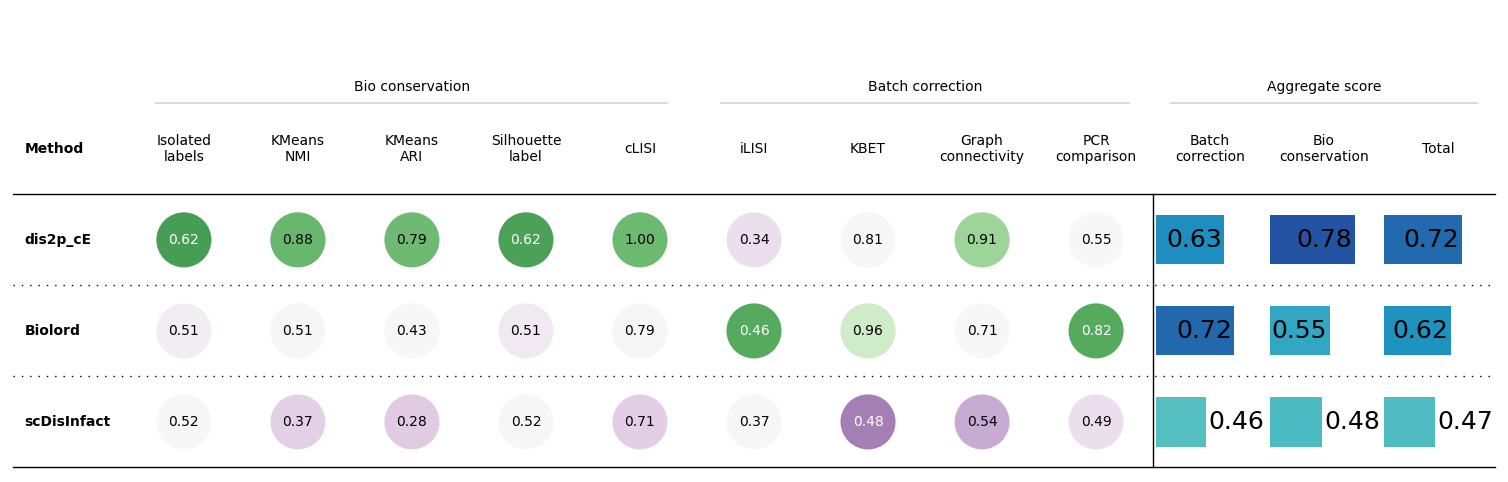

In [26]:
plot_results_table(df_mean)